# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

# Load and Set

In [3]:
dt = 0.01
global cut_state_num
cut_state_num = 8

channelnumber = 30
annots = loadmat('D:\\GoogleDrive\\retina\\Troy\'s data\\20210908\\SplitData\\diode_OU_tau=500ms_cutoff=1_mean=10_amp=2_11-Aug-2021_0', squeeze_me = True)
sampling_rate = 20000
TimeStamps = annots['TimeStamps']
x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
x = x[::int(sampling_rate*dt)]
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
T=np.arange(len(x))*dt
Spike = annots['Spikes'][channelnumber-1]
Spike = Spike[np.where(Spike>TimeStamps[0])[0][0]:np.where(Spike<TimeStamps[1])[0][-1]]-TimeStamps[0]

xstate, _ = EqualState(x, cut_state_num)

# Statics of ISI

In [4]:
HeadSpikeEnd = np.hstack((0, Spike, T[-1]+dt))
ISI = np.diff(HeadSpikeEnd)

(1400.0, 1600.0)

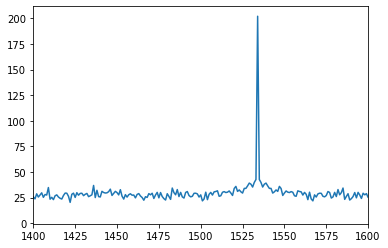

In [5]:
plt.plot(np.correlate(ISI,ISI,'same'))
plt.xlim(1400,1600)

(array([2.673e+03, 1.860e+02, 9.800e+01, 5.500e+01, 3.000e+01, 1.500e+01,
        4.000e+00, 1.000e+00, 3.000e+00, 4.000e+00]),
 array([9.99999997e-05, 2.37425000e-01, 4.74750000e-01, 7.12075000e-01,
        9.49400000e-01, 1.18672500e+00, 1.42405000e+00, 1.66137500e+00,
        1.89870000e+00, 2.13602500e+00, 2.37335000e+00]),
 <BarContainer object of 10 artists>)

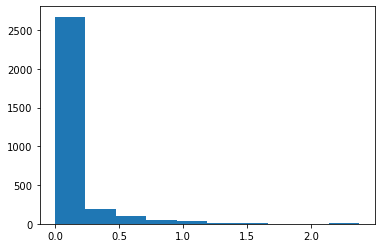

In [6]:
plt.hist(ISI)

## for 'event = bin' case

In [7]:
rstate, _ = np.histogram(Spike, np.append(T, T[-1]+dt))

ISI_bin = np.zeros(len(rstate))

counter = 0
for j in range(len(rstate)):
    counter += rstate[j]
    ISI_bin[j] = (HeadSpikeEnd[counter+1]-HeadSpikeEnd[counter-rstate[j]])/(rstate[j]+1)
    
timestate, _ = EqualState(ISI, cut_state_num)

(array([378., 387., 381., 384., 382., 386., 383., 388.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]),
 <BarContainer object of 8 artists>)

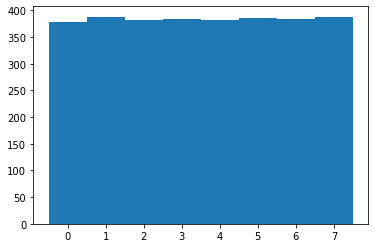

In [8]:
plt.hist(timestate,np.arange(cut_state_num+1)-0.5)

## for 'event = spike' case

In [9]:
negshift=-1 # second
posshift=1 # second
shiftlen=(posshift-negshift)/dt+1
timeshift=np.linspace(negshift,posshift,int(shiftlen))
bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
MIxr = np.zeros(len(bitshift))
Hx = np.zeros(len(bitshift))
Hr = np.zeros(len(bitshift))
xx_list = []

for i in range(len(bitshift)):
    shift=bitshift[i]
    if shift>0:
        xx=xstate[shift:]
        rr=rstate[:(-1*shift)]
        SS=np.hstack((HeadSpikeEnd[:sum(rr)+1],HeadSpikeEnd[-1]-timeshift[i]))
    elif shift==0:
        xx=xstate
        rr=rstate
        SS=HeadSpikeEnd
    elif shift<0:
        xx=xstate[:shift]
        rr=rstate[(-1*shift):]
        SS=np.hstack((-timeshift[i],HeadSpikeEnd[-sum(rr)-1:]))
    if len(SS)-2 != sum(rr):
        print(timeshift[i], SS[0:2], i)
        print(len(SS), sum(rr))

    new_xx = []
    shifted_ISI,_  = EqualState(np.diff(SS),cut_state_num)
    post_ISI = shifted_ISI[1:]
    pre_ISI = shifted_ISI[:-1]
    for j in np.squeeze(np.where(rr != 0)):
        for k in range(rr[j]):
            new_xx.append(xx[j])

    new_xx = np.array(new_xx)
    # new_rr = post_ISI
    new_rr = pre_ISI

    xedges = np.append(np.unique(new_xx),(max(new_xx)+1))
    redges = np.append(np.unique(new_rr),(max(new_rr)+1))
    N, _, _ = np.histogram2d(new_xx, new_rr, bins=(xedges, redges)) 
    px=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis]
    pr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :]
    pxr=N/np.sum(N)

    MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
    Hx[i]=np.nansum(px*np.log2(1/px))/dt
    Hr[i]=np.nansum(pr*np.log2(1/pr))/dt

    xx_list.append(new_xx.copy())

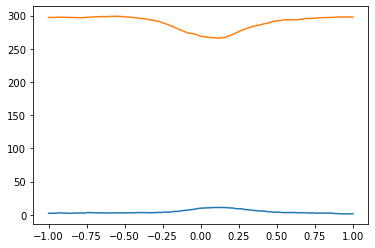

In [10]:
plt.plot(timeshift,MIxr)
plt.plot(timeshift,Hx)
# plt.plot(timeshift,Hr)

Text(0.5, 1.0, '$\\delta$t=0.2 s')

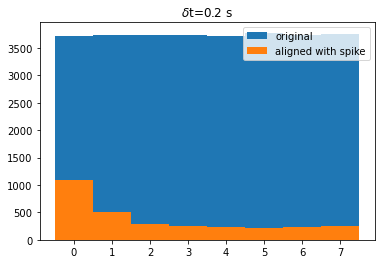

In [11]:
shiftIndex = 120

plt.hist(xstate, np.arange(cut_state_num+1)-0.5, label = 'original')
plt.hist(xx_list[shiftIndex], np.arange(cut_state_num+1)-0.5, label = 'aligned with spike')
plt.legend()
plt.title(r'$\delta$t='+str(round(timeshift[shiftIndex], 3))+' s')